<a href="https://colab.research.google.com/github/petergchang/sarkka-jax/blob/main/Ch3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3. Batch and Recursive Bayesian Estimation

This notebook replicates the figures of Chapter 3 of  Särkkä's "Bayesian Filtering and Smoothing" using JAX.

Simo Särkkä (2013), “Bayesian Filtering and Smoothing,” Cambridge University Press. Available: https://users.aalto.fi/~ssarkka/pub/cup_book_online_20131111.pdf

This JAX translation is by Peter G. Chang ([@petergchang](https://github.com/petergchang))



## 3.0 Imports

In [7]:
%matplotlib inline

import jax
import jax.numpy as jnp
import jax.random as jr
from jax import vmap
from jax import lax

import matplotlib.pyplot as plt

In [37]:
# For pretty print of ndarrays
jnp.set_printoptions(formatter={'float_kind':"{:.2f}".format})

## 3.1 Batch Linear Regression

First, we generate some data that approximately replicates Figure 3.1.

In [30]:
# Generate grid
X = jnp.linspace(0.0, 1.0, 100).reshape(-1,1)

# Define linear regression model
def lr_model(key, x, theta, var):
    epsilon = jr.normal(key)*var
    return theta[1] * x + theta[0] + epsilon
lr_model_vmap = vmap(lr_model, in_axes=(0, 0, None, None), out_axes=0)

# True parameter values
theta = jnp.array([1, 0.5])

# True signal
Y_tr = theta[1] * X + theta[0]

# Generate dataset (var = 0.1)
var = 0.1
keys = jr.split(jr.PRNGKey(42), X.shape[0])
Y = lr_model_vmap(keys, X, theta, var)

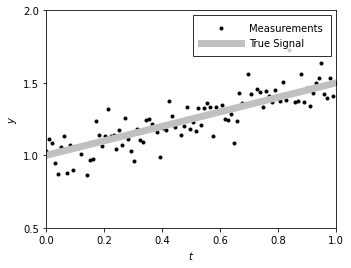

In [31]:
# Plot the generated data
plt.figure()
plt.plot(X, Y, 'k.', label='Measurements')
plt.plot(X, Y_tr, color='silver', linewidth=7, label="True Signal")
plt.xlabel('$t$'); plt.ylabel('$y$')
plt.xlim(0, 1); plt.ylim(0.5, 2)
plt.yticks(jnp.arange(0.5, 2.1, 0.5))
plt.gca().set_aspect(0.5)
plt.legend(loc=1, borderpad=0.8, handlelength=4, fancybox=False, edgecolor='k');
plt.show()

Now we apply the batch solution, given by equation (3.4):
\begin{align*}
    \textbf{m}_T &= \left[ \textbf{P}_0^{-1} + \frac{1}{\sigma^2} \textbf{H}^T \textbf{H} \right]^{-1} \left[ \frac{1}{\sigma^2} \textbf{H}^T \textbf{y} + \textbf{P}_0^{-1} \textbf{m}_0 \right] \\
\textbf{P}_T &= \left[ \textbf{P}_0^{-1} + \frac{1}{\sigma^2} \textbf{H}^T \textbf{H} \right]^{-1}
\end{align*}
where our we arbitrarily set our prior distribution to:
\begin{align*}
    p(\theta) &= \mathcal{N}(\theta \mid \textbf{m}_0, \textbf{P}_0) = \mathcal{N}(\theta \mid (0, 0)^T, \mathcal{I})
\end{align*}

In [38]:
# Parameter update model
def update_params(m_prior, P_prior, X, Y, meas_var):
    H = jnp.vstack(([1, x[0]] for x in X))
    P_post = jnp.linalg.inv(jnp.linalg.inv(P_0) + H.T @ H / meas_var)
    m_post = P_post @ (H.T @ Y / meas_var + jnp.linalg.inv(P_0) @ m_0)
    return m_post, P_post 

In [39]:
# Prior parameters
m_0 = jnp.array([0,0], dtype=jnp.float32).reshape(2,-1)
P_0 = jnp.eye(2)

# Posterior parameters
m_T, P_T = update_params(m_0, P_0, X, Y, var)

print(f'{"True theta value": <20} = {theta}')
print(f'{"Posterior theta mean": <20} = {m_T.reshape(1,-1)[0]}')

True theta value     = [1.00 0.50]
Posterior theta mean = [0.98 0.53]


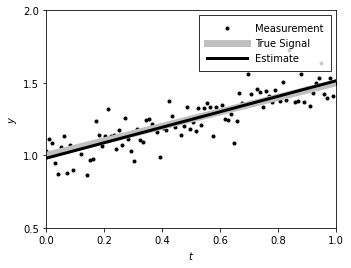

In [40]:
# Posterior estimation
Y_post = m_T[1] * X + m_T[0]

# Plot the generated data
plt.figure()
plt.plot(X, Y, 'k.', label='Measurement')
plt.plot(X, Y_tr, color='silver', linewidth=7, label="True Signal")
plt.plot(X, Y_post, color='k', linewidth=3, label="Estimate")
plt.xlabel('$t$'); plt.ylabel('$y$')
plt.xlim(0, 1); plt.ylim(0.5, 2)
plt.yticks(jnp.arange(0.5, 2.1, 0.5))
plt.gca().set_aspect(0.5)
plt.legend(loc=1, borderpad=0.8, handlelength=4, fancybox=False, edgecolor='k');
plt.show()

## 3.2 Recursive Linear Regression

We use equation (3.7) to replicate Figures 3.3 and 3.4.

In [49]:
def recursive_lin_reg(m_0, P_0, obs_var, X, Y):
    num_timesteps = len(Y)

    def _step(carry, t):
        m_k, P_k = carry
        H_k = jnp.array([[1, X[t,0]]])

        # Compute params after single update
        P_post = jnp.linalg.inv(jnp.linalg.inv(P_k) + H_k.T @ H_k / obs_var)
        m_post = P_post @ (H_k.T * Y[t] / obs_var + jnp.linalg.inv(P_k) @ m_k)
        return (m_post, P_post), (m_post, P_post)

    carry = (m_0, P_0)
    _, (ms, Ps) = lax.scan(
        _step, carry, jnp.arange(num_timesteps)
    )
    return ms, Ps

# Run recursive linear regression
ms, Ps = recursive_lin_reg(m_0, P_0, var, X, Y)

First, we replicate Figure 3.3.

In [50]:
# Batch mean result
theta1_bmean = jnp.ones(X.shape) * m_T[0]
theta2_bmean = jnp.ones(X.shape) * m_T[1]

# Recursive mean results
theta1_rmean = ms[:,0]
theta2_rmean = ms[:,1]

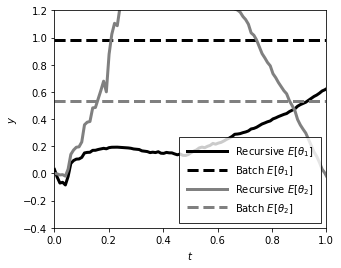

In [51]:
# Plot the generated data
plt.figure()
plt.plot(X, theta1_rmean, 'k', linewidth=3, label=r"Recursive $E[\theta_1]$")
plt.plot(X, theta1_bmean, 'k--', linewidth=3, label=r"Batch $E[\theta_1]$")
plt.plot(X, theta2_rmean, color='gray', linewidth=3, label=r"Recursive $E[\theta_2]$")
plt.plot(X, theta2_bmean, '--', color='gray', linewidth=3, label=r"Batch $E[\theta_2]$")
plt.xlabel('$t$'); plt.ylabel('$y$')
plt.xlim(0, 1); plt.ylim(-0.4, 1.2)
plt.yticks(jnp.arange(-0.4, 1.3, 0.2))
plt.gca().set_aspect(0.5)
plt.legend(loc=4, borderpad=0.8, handlelength=4, fancybox=False, edgecolor='k');
plt.show()

Next, we replicate Figure 3.4.

In [52]:
# Batch var result
theta1_bvar = jnp.ones(X.shape) * P_T[0,0]
theta2_bvar = jnp.ones(X.shape) * P_T[1,1]

# Recursive var results
theta1_rvar = Ps[:,0,0]
theta2_rvar = Ps[:,1,1]

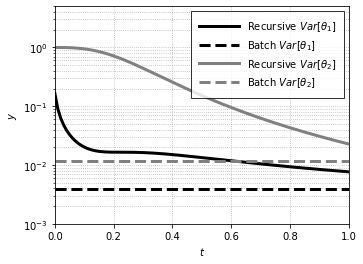

In [53]:
# Plot the generated data
plt.figure()
plt.plot(X, theta1_rvar, 'k', linewidth=3, label=r"Recursive $Var[\theta_1]$")
plt.plot(X, theta1_bvar, 'k--', linewidth=3, label=r"Batch $Var[\theta_1]$")
plt.plot(X, theta2_rvar, color='gray', linewidth=3, label=r"Recursive $Var[\theta_2]$")
plt.plot(X, theta2_bvar, '--', color='gray', linewidth=3, label=r"Batch $Var[\theta_2]$")
plt.xlabel('$t$'); plt.ylabel('$y$')
plt.yscale("log")
plt.xlim(0, 1); plt.ylim(1e-3, 5)
plt.gca().set_aspect(0.2)
plt.legend(loc=1, borderpad=0.8, handlelength=4, fancybox=False, edgecolor='k');
plt.grid(True, which="both", ls=':')

## 3.4 Drift Model for Linear Regression

First, we generate some sinusoidal signal dataset.

In [54]:
# Generate grid
X = jnp.linspace(0.0, 2.0, 200).reshape(-1,1)

# Define sinusoidal model
def sin_model(key, x, var):
    epsilon = jr.normal(key)*var
    return jnp.sin(jnp.pi * x) + epsilon
sin_model_vmap = vmap(sin_model, in_axes=(0, 0, None), out_axes=0)

# True signal
Y_tr = jnp.sin(jnp.pi * X)

# Generate dataset (var = 0.2)
var = 0.2
keys = jr.split(jr.PRNGKey(42), X.shape[0])
Y = sin_model_vmap(keys, X, var)

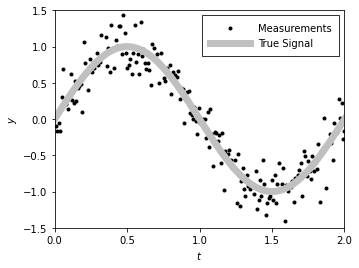

In [55]:
# Plot the generated data
plt.figure()
plt.plot(X, Y, 'k.', label='Measurements')
plt.plot(X, Y_tr, color='silver', linewidth=7, label="True Signal")
plt.xlabel('$t$'); plt.ylabel('$y$')
plt.xlim(0, 2); plt.ylim(-1.5, 1.5)
plt.xticks(jnp.arange(0, 2.1, 0.5))
plt.yticks(jnp.arange(-1.5, 1.6, 0.5))
plt.gca().set_aspect(0.5)
plt.legend(loc=1, borderpad=0.8, handlelength=4, fancybox=False, edgecolor='k');
plt.show()

Next, we use equation (3.10) to compute the filtered estimate.

Note that the difference between the Gaussian random walk model and the linear regression model is that at each "predict" step, the filter injects additional noise:
\begin{align*}
    \textbf{P}_k^{-} = \textbf{P}_{k-1} + \textbf{Q}
\end{align*}
which leads to larger $\textbf{K}_k$, placing higher weights to the subsequent measurements, allowing for a more realistic tracking of a dynamic, rather than static, parameter.

In [71]:
# Random walk filter
def random_walk_filter(m_0, P_0, Q, obs_var, X, Y):
    num_timesteps = len(Y)

    def _step(carry, t):
        m_k, P_k = carry
        H_k = jnp.array([[1, X[t,0]]])

        # Predict using Chapman-Kolmogorov
        m_pred = m_k
        P_pred = P_k + Q

        # Update on single observation
        S = H_k @ P_pred @ H_k.T + obs_var
        K = P_pred @ H_k.T @ jnp.linalg.inv(S)
        m_post = m_pred + K @ (Y[t] - H_k @ m_pred)
        P_post = P_pred - K @ S @ K.T
        return (m_post, P_post), (m_post, P_post)

    carry = (m_0, P_0)
    _, (ms, Ps) = lax.scan(
        _step, carry, jnp.arange(num_timesteps)
    )
    return ms, Ps

In [72]:
# Plot function
def plot_sin_estimates(X, Y, Y_tr, X_est, Y_est, xrlim, loc):
    plt.figure()
    plt.plot(X, Y, 'k.', label='Measurements')
    plt.plot(X, Y_tr, color='silver', linewidth=7, label="True Signal")
    plt.plot(X_est, Y_est, 'k-', linewidth=2, label="Estimate")
    plt.xlabel('$t$'); plt.ylabel('$y$')
    plt.xlim(0.0, xrlim); plt.ylim(-1.5, 1.5)
    plt.xticks(jnp.arange(0, xrlim+0.1, 0.5))
    plt.yticks(jnp.arange(-1.5, 1.6, 0.5))
    plt.gca().set_aspect(0.5)
    plt.legend(loc=loc, borderpad=0.8, handlelength=4, fancybox=False, edgecolor='k');
    plt.show()

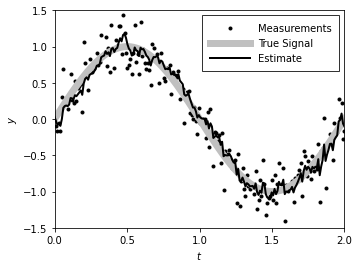

In [73]:
# Prior parameters
m_0 = jnp.array([0,0], dtype=jnp.float32).reshape(2,-1)
P_0 = jnp.eye(2)
Q = jnp.eye(2) * 0.01

# Run recursive linear regression
m_rw, P_rw = random_walk_filter(m_0, P_0, Q, var, X, Y)

# Compute estimate values
Y_est = m_rw[:,1] * X + m_rw[:,0]

# Plot random walk estimates
plot_sin_estimates(X, Y, Y_tr, X, Y_est, 2.0, 1)

## 3.5 State Space model for Linear Regression with Drift

Since we use `jnp.linspace` to generate the dataset, the timesteps are equidistant from one another. 

Therefore, we can also use a Kalman filter to replicate the random walk filter result from above (and Figure 3.6).

In [78]:
# Kalman filter assuming constant transition and measurement models
def kalman_filter(m_0, P_0, H, R, A, Q, Y):
    num_timesteps = len(Y)

    def _step(carry, t):
        m_k, P_k = carry

        # Prediction step
        m_pred = A @ m_k
        P_pred = A @ P_k @ A.T + Q

        # Update step
        S = H @ P_pred @ H.T + R
        K = P_pred @ H.T @ jnp.linalg.inv(S)
        m_post = m_pred + K @ (Y[t] - H @ m_pred)
        P_post = P_pred - K @ S @ K.T
        return (m_post, P_post), (m_post, P_post)
        
    carry = (m_0, P_0)
    _, (ms, Ps) = lax.scan(
        _step, carry, jnp.arange(num_timesteps)
    )
    return ms, Ps

In [ ]:
# Parameters
dt = (X[1]-X[0])[0]
H = jnp.array([[1, 0]])
A = jnp.array([[1, dt],
               [0,  1]])

# Run Kalman filter
m_kf, P_kf = kalman_filter(m_0, P_0, H, var, A, Q, Y)

# Compute estimate values
Y_est = m_kf[:,0]

# Plot Kalman filter estimates
plot_sin_estimates(X, Y, Y_tr, X, Y_est, 2.0, 1)

Even though the chapter does not cover RTS smoothers, I will implement one to replicate Figure 3.7 for completeness.

In [80]:
def rts_smoother(m_0, P_0, H, R, A, Q, Y):
    num_timesteps = len(Y)

    # Run kalman filter and reverse
    m_kfs, P_kfs = kalman_filter(m_0, P_0, H, R, A, Q, Y)
    m_kfs, P_kfs = m_kfs[::-1], P_kfs[::-1]

    def _step(carry, t):
        m_k, P_k = carry
        m_kf, P_kf = m_kfs[t], P_kfs[t]

        # Prediction step
        m_pred = A @ m_kf
        P_pred = A @ P_kf @ A.T + Q

        # Update step
        G = P_kf @ A.T @ jnp.linalg.inv(P_pred)
        m_smoothed = m_kf + G @ (m_k - m_pred)
        P_smoothed = P_kf + G @ (P_k - P_pred) @ G.T
        return (m_smoothed, P_smoothed), (m_smoothed, P_smoothed)

    carry = (m_kfs[0], P_kfs[0])
    _, (m_rts, P_rts) = lax.scan(
        _step, carry, jnp.arange(1, num_timesteps)
    )
    # Append smoothed (= filtered) value for final timestep
    m_rts = jnp.append(m_rts[::-1], jnp.expand_dims(m_kfs[0], 0), 0)
    P_rts = jnp.append(P_rts[::-1], jnp.expand_dims(P_kfs[0], 0), 0)
    return m_rts, P_rts

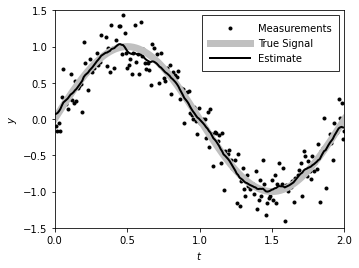

In [81]:
# Run RTS smoother
ms, Ps = rts_smoother(m_0, P_0, H, var, A, Q, Y)

# Compute estimate values
Y_est = ms[:,0]

# Plot RTS smoother estimates
plot_sin_estimates(X, Y, Y_tr, X, Y_est, 2.0, 1)

Finally, we replicate Figure 3.8 by running the usual Kalman filter, only iterating the prediction step for regressor values without the corresponding observation values.

In [82]:
def predictor(m_0, P_0, H, R, A, Q, Y, pred_steps):
    def _step(carry, t):
        m_k, P_k = carry

        # Prediction step
        m_pred = A @ m_k
        P_pred = A @ P_k @ A.T + Q
        return (m_pred, P_pred), (m_pred, P_pred)

    # Run RTS smoother on available observations
    m_rts, P_rts = rts_smoother(m_0, P_0, H, R, A, Q, Y)
    carry = (m_rts[-1], P_rts[-1])
    _, (ms, Ps) = lax.scan(
        _step, carry, jnp.arange(pred_steps)
    )
    return jnp.append(m_rts, ms, 0), jnp.append(P_rts, Ps, 0)

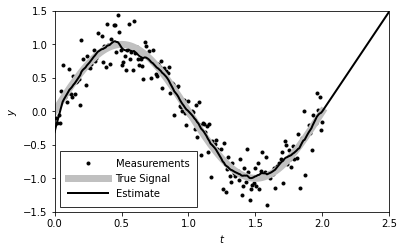

In [83]:
# Prior distribution to replicate Figure 3.8
m_0 = jnp.array([0,20], dtype=jnp.float32).reshape(2,-1)

# Generate prediction grid
X_pred = jnp.linspace(0.0, 2.5, 250).reshape(-1,1)

# Run predictor
m_pred, P_pred = predictor(m_0, P_0, H, var, A, Q, Y, 50)

# Compute estimate values
Y_pred = m_pred[:,0]

# Plot RTS smoother estimates
plot_sin_estimates(X, Y, Y_tr, X_pred, Y_pred, 2.5, 3)